In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as mpl
import pandas as pd

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
from matplotlib.patches import Rectangle
import cartopy.feature as cfeature

In [4]:
colors = ["#6c757d","#009969","#8b0053","#ff9c23","#00639a","#9359ba","#a0b2cd","#96bd52","#847149","#c45245"]
legend_font = 18
title_font = 32
axis_font = 16

In [2]:
    df_hurdat = pd.read_csv("/Users/zaibethcarlofrontera/Library/CloudStorage/GoogleDrive-zcf.atmos@gmail.com/My Drive/WORK/research/phase_7/s2s_hurricane_prediction-main/data/HURDAT_49toRealtime21.csv",
#                             header=None,
#                             names=["date", "time", "count", "storm_type", "latitude", "longitude", "intensity"],
                            skipinitialspace=True,
                            ).iloc[:,1:]

    # grab the rows with storm information and label the storms
    df_hurr = pd.DataFrame()
    for index, row in df_hurdat.iterrows():
        if row["date"][:2] == "EP":
            # print(df_hurdat.iloc[index:index+int(row["count"])+1])
            df = df_hurdat.iloc[index + 1:index + int(row["count"]) + 1].copy()
            df["storm_name"] = row["date"]
            df_hurr = pd.concat([df_hurr, df], ignore_index=True)
    df_hurr = df_hurr.drop("count", axis=1)

    # add year, month and day to the dataframe
    year = np.zeros((df_hurr.shape[0],))
    month = np.zeros((df_hurr.shape[0],))
    day = np.zeros((df_hurr.shape[0],))
    for index, row in df_hurr.iterrows():
        year[index] = row["date"][:4]
        month[index] = row["date"][4:6]
        day[index] = row["date"][6:]

    df_hurr["year"] = year
    df_hurr["month"] = month
    df_hurr["day"] = day
    df_hurr = df_hurr[
        ['date', "year", "month", "day", "time", "storm_name", "storm_type", "latitude", "longitude", "intensity"]]

    # get years
    df_hurr = df_hurr[
        (df_hurr["year"] >= 1979) & (df_hurr["year"] <= 2021)].reset_index(drop=True)


#     df = df_hurr[(df_hurr["storm_type"] == "HU") | (df_hurr["storm_type"] == "TS")].copy()
    df = df_hurr[(df_hurr['intensity']>=34) | (df_hurr['intensity']>=64)].copy()
#     df = df_hurr[df_hurr['intensity']>=64].copy()
    df_selection = pd.DataFrame()
    unique_storms = np.unique(df["storm_name"])
  
    for name in unique_storms:
        irows = np.where(df["storm_name"] == name)[0]
        ifirst = np.argmin(df["date"].iloc[irows])

            # grab ifirst:ifirst+1 so that it keeps the dataframe in rows, this is just a little trick
        df_selection = pd.concat([df_selection, df.iloc[irows[ifirst:ifirst + 1]]].copy(), ignore_index=True, )
    df_selection = df_selection.sort_values(by="date").reset_index(drop=True) #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


    df_hurr = df_selection.copy()
    
    
    #addition
    
    lat=np.empty(len(df_hurr['latitude'])) #!!
    lon=np.empty(len(df_hurr['longitude']))
    
    for ilat in range(0,len(df_hurr['latitude'])):
        if len(df_hurr['latitude'][ilat])==5:
            lat[ilat]=float(df_hurr['latitude'][ilat][:4])
        elif len(df_hurr['latitude'][ilat])==4:
            lat[ilat]=float(df_hurr['latitude'][ilat][:3])
        elif len(df_hurr['latitude'][ilat])>5 or len(df_hurr['latitude'][ilat])<4:
            print(df_hurr['latitude'][ilat])
        
        if (lat[ilat] < 5) or (lat[ilat]>25): #limiting the region that is being studied 
            lat[ilat] = np.nan 
        
    for ilon in range(0,len(df_hurr['longitude'])):
        if len(df_hurr['longitude'][ilon])==6:
    #         print((df_hurr['longitude'][ilon][:5]))
            lon[ilon]=float(df_hurr['longitude'][ilon][:5])
        elif len(df_hurr['longitude'][ilon])==5:
    #         print((df_hurr['longitude'][ilon][:4]))
            lon[ilon]=float(df_hurr['longitude'][ilon][:4])
        elif len(df_hurr['longitude'][ilon])<5 or len(df_hurr['longitude'][ilon])>6:
            print(df_hurr['longitude'][ilon][:3])
        
        if (lon[ilon] < 90) or (lon[ilon]>120): #limiting the region that is being studied 
            lon[ilon] = np.nan 
    
    df_selection['latitude'] = lat
    df_selection['longitude'] = lon
    
    df_hurr = df_selection.dropna().reset_index(drop=True)


In [6]:
import matplotlib.path as mpath

def get_hurricane():
    u = np.array([  [2.444,7.553],
                    [0.513,7.046],
                    [-1.243,5.433],
                    [-2.353,2.975],
                    [-2.578,0.092],
                    [-2.075,-1.795],
                    [-0.336,-2.870],
                    [2.609,-2.016]  ])
    u[:,0] -= 0.098
    codes = [1] + [2]*(len(u)-2) + [2] 
    u = np.append(u, -u[::-1], axis=0)
    codes += codes

    return mpath.Path(2*u, codes, closed=False)

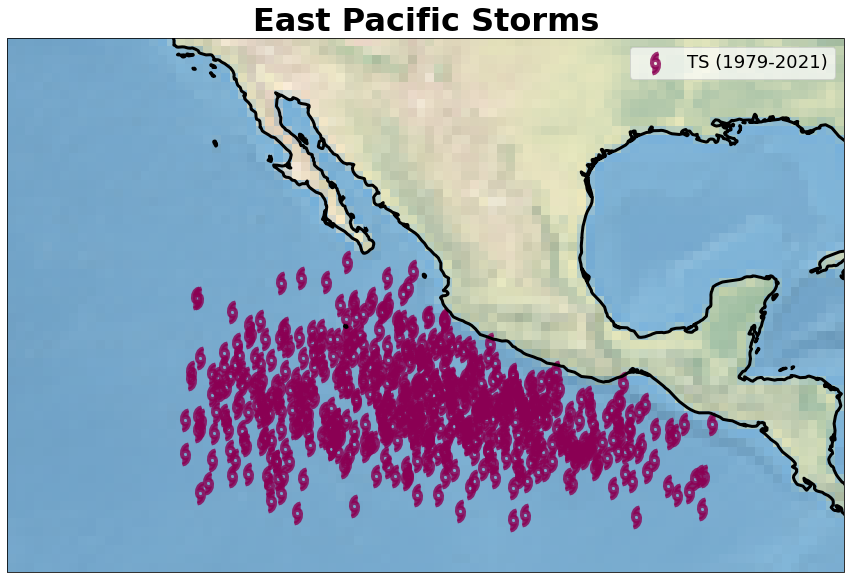

In [55]:
hurricane = get_hurricane()

fig = plt.figure(figsize=(15,10))

# Set the axes using the specified map projection
ax=plt.axes(projection=ccrs.PlateCarree())

# Make a filled contour plot
ax.grid(alpha=0.4)
ax.scatter(df_hurr['longitude']*-1, df_hurr['latitude'],
           s=400,
           marker=hurricane,linewidth=4, color = colors[2],
           edgecolors=colors[2], alpha = .8,
           transform = ccrs.PlateCarree(), label = 'TS (1979-2021)')

ax.set_xlim(left=-130,right=-83)
plt.ylim([5,35])
# ax.set_xticks(np.arange(-130,-80,10))
# ax.set_yticks(range(0,30,5))
ax.set_title('East Pacific Storms',fontsize=title_font, weight = 'bold')
ax.tick_params(axis = 'both',direction='out', length=10, width=1.5)
# Add coastlines
ax.coastlines(lw = 3)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.stock_img()
ax.coastlines()
# ax.add_feature(cfeature.OCEAN)
plt.legend(facecolor='white', framealpha=.7, frameon=True, fontsize=legend_font, bbox_to_anchor = (1, 1))
# plt.xticks(np.arange(-125,-80,10), ['125W', '115W', '105W', '95W', '85W'], fontsize = axis_font, weight = 'bold')
# plt.yticks(range(0,30,5), ['0','5N', '10N','15N', '20N', '25N'],fontsize = axis_font, weight = 'bold')
# plt.savefig('/Users/zaibethcarlofrontera/Library/CloudStorage/GoogleDrive-zcf.atmos@gmail.com/My Drive/OTHER/EP_TS_1979_2021_color.png', dpi=300,facecolor='white', transparent=False,bbox_inches='tight')
plt.show()